# SIMEX notebook for start-to-end single-particle imaging simulation

In [1]:
# Import all SimEx modules
from SimEx import *
# Import all SimEx modules
from SimEx.Calculators.WavePropagator import WavePropagator
from SimEx.Calculators.GaussianPhotonSource import GaussianPhotonSource
from SimEx.Parameters.WavePropagatorParameters import WavePropagatorParameters
from SimEx.Parameters.GaussWavefrontParameters import GaussWavefrontParameters
from SimEx.Analysis.XFELPhotonAnalysis import XFELPhotonAnalysis
from SimEx.Utilities.Units import electronvolt, meter, joule, radian
import numpy

initializing ocelot...


# The SPB-SFX instrument layout at European XFEL

![Picture showing the SPB-SFX instrument layout at European XFEL](../include/SPB-SFX_setup_811.jpg "SPB-SFX instrument layout")

# Simplified beamline used in this simulation 

![Picture showing the simplified beamline for the simulation](../include/s2e_spi_scheme.png "Simplified beamline used in this simulation")

## Step 1: Aquire XFEL source wavefront file from database

https://in.xfel.eu/xpd

## Step 2a: Propagation through beamline

### Import beamline for WPG 

In [2]:
from prop import exfel_spb_kb_beamline

![Picture showing the SPB-SFX beamline optical setup with distances](../include/SPB-SFX_optics.png "Optical distances in the SPB-SFX beamline")

### Propagate SASE pulses to sample interaction point

In [3]:
propagation_parameters = WavePropagatorParameters(beamline=exfel_spb_kb_beamline,
                           backengine_mpicommand="mpirun -np24")

In [6]:
import mpi4py

In [4]:
propagator = WavePropagator(parameters=propagation_parameters,
                            input_path='FELsource_out_0000001.h5',
                            output_path='prop_out.h5',
                            
                            
                        )

In [5]:
propagator.backengine()

FileNotFoundError: [Errno 2] No such file or directory: 'mpirun': 'mpirun'

In [7]:
!mpirun --version

/bin/sh: mpirun: command not found


In [6]:
propagator.saveH5()

Analyse propagated wavefronts

In [9]:
prop_analysis=XFELPhotonAnalysis(input_path='prop_out.h5')


 Start initialization.

 Loading wavefront from prop_out.h5.
 ... done.

 Getting intensities.
 ... done.
 Data dimensions =  (42, 84, 651)

 Masking NANs.
 ... done.


## Plot FEL spectrum before propagation

In [ ]:
# Plot FEL spectrum at source and after propagation
prop_analysis.plotTotalPower(spectrum=True)

## Plot FEL spectrum after propagation

In [13]:
prop_analysis.plotTotalPower(spectrum=True)

NameError: name 'prop_analysis' is not defined

In [14]:
# Plot source and sample intensity map
source_analysis.plotIntensityMap()

NameError: name 'source_analysis' is not defined

In [ ]:
prop_analysis.plotIntensityMap()

## Step 3: Photon-Matter interaction

In [15]:
pmi_parameters={"number_of_trajectories" : 1,
                "random_rotation" : False}

photon_matter_interactor=XMDYNPhotonMatterInteractor(parameters=pmi_parameters,
                                                         input_path='prop_out.h5',
                                                         output_path='pmi_out',
                                                         sample_path='2nip.pdb')

NameError: name 'XMDYNPhotonMatterInteractor' is not defined

In [ ]:
photon_matter_interactor.backengine()
photon_matter_interactor.saveH5()

## Step 4: Scattering 

### Configure Detector geometry

#### One panel

In [16]:
panel = DetectorPanel(ranges={"fast_scan_min" : 0, "fast_scan_max" : 100,
                              "slow_scan_min" : 0, "slow_scan_max" : 100},
                      pixel_size=6*220.0e-6*meter,
                      energy_response=1.0/electronvolt,
                      distance_from_interaction_plane=0.13*meter,
                      corners={"x" : -49, "y": -49},
                      saturation_adu=1.e6,
                      )

NameError: name 'DetectorPanel' is not defined

In [17]:
detector_geometry = DetectorGeometry(panels=panel,)

NameError: name 'DetectorGeometry' is not defined

### Configure the Diffractor Parameters

In [18]:
diffraction_parameters = SingFELPhotonDiffractorParameters(
                                               uniform_rotation=False,
                                               slice_interval=100,
                                               number_of_slices=100,
                                               number_of_diffraction_patterns=50,
                                               detector_geometry=detector_geometry,
                                               forced_mpi_command='mpirun -np 50',
                                              )

NameError: name 'SingFELPhotonDiffractorParameters' is not defined

### Initialize the Diffractor 

In [37]:
diffractor = SingFELPhotonDiffractor(parameters=diffraction_parameters,
                                     input_path='pmi/',
                                     output_path="diffr")

### Run the scattering simulation

In [38]:
diffractor.backengine()
diffractor.saveH5()

## Analysis 

### Setup analysis object 

In [90]:
spi_analysis = DiffractionAnalysis(diffractor.output_path,
                                   pattern_indices=range(1,50),
                                   poissonize=True,
                                   )

In [59]:
spi_analysislysis.animatePatterns("diffr_animated.gif")

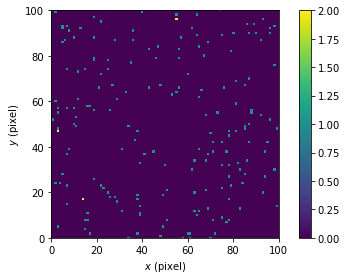

In [92]:
spi_analysis.plotPattern(operation=numpy.sum,logscale=False)

In [94]:
import wpg

In [95]:
wf = wpg.Wavefront()

In [96]:
wf.load_hdf5('prop_out.h5')

In [99]:
wf_intensity = wf.get_intensity()

In [139]:
wf_intensity.shape

(42, 84, 651)

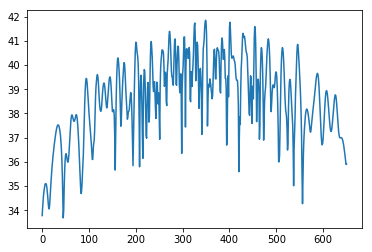

In [151]:
plot([numpy.log(wf_intensity[:,:,i].max()) for i in range(651)])

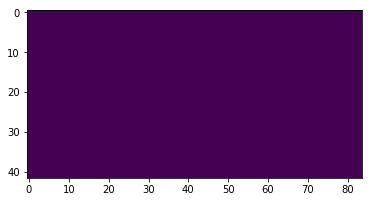

In [155]:
for i in range(wf_intensity.shape[-1]):
    if wf_intensity[:,:,i].max() < 1e14:
        continue
    imshow(wf_intensity[:,:,i], norm=Norm(vmin=1e15, vmax=1.5e18) )
    savefig("include/wf_intensity/wf_intensity_{0:03d}.png".format(i))
    #imsave("include/wf_intensity/wf_intensity_{0:03d}.png".format(i), wf_intensity[:,:,i], vmin=1e15, vmax=1.5e18 )

In [154]:
from matplotlib.pyplot import imshow, colorbar, imsave, plot, savefig
from matplotlib.colors import Normalize as Norm

In [101]:
wf_intensity.shape

(42, 84, 651)

In [55]:
mask = numpy.ones((101,101))
mask[40:60,40:60]=0.0

In [91]:
spi_analysis.mask = mask

# Cleanup

In [1]:
import os, shutil

In [2]:
# Cleanup previous run
dirs_to_remove=['diffr, pmi']
files_to_remove=['diffr.h5','5udc.pdb']

In [3]:
for d in dirs_to_remove:
    if os.path.isdir(d):
        shutil.rmtree(d)
for f in files_to_remove:
    if os.path.isfile(f):
        os.remove(f)
    